In [198]:
# importing the required Libraries (allowed)
import numpy as np
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy.stats import mode
import warnings
import random # just to randomly split data
import time # to note the execution time
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')


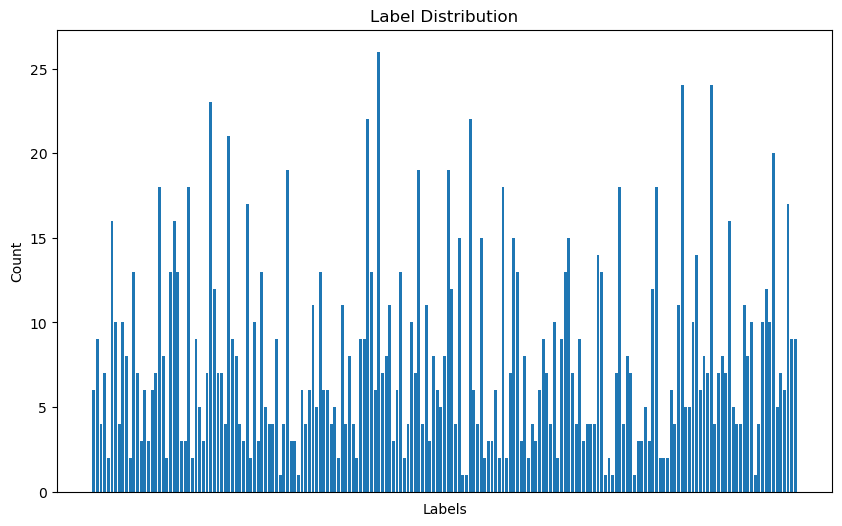

In [291]:
# Draw a graph that shows the distribution of the various labels across the entire
# dataset. You are allowed to use standard libraries like Matplotlib.

dataset = np.load('./../../data/data.npy', allow_pickle=True)

# since labels are there in 4th col
labels = dataset[:, 3]

unique_labels, label_counts = np.unique(labels, return_counts=True)

# plotting labels districution
plt.figure(figsize=(10, 6))

plt.bar(unique_labels, label_counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks([]) # label names are removed since they are not readable

plt.show()


In [158]:
# function to save the observed values
def save_observations(knn1,total_time):
    file1 = open('./results.txt','a')

    if(total_time>=0):
        file1.write(str(knn1.k)+'\t'
                    +('ResNet' if knn1.emb==1 else 'VIT   ')+'\t\t'
                    +knn1.dist_metric+'\t\t'
                    +str(knn1.acc)+'\t\t'
                    +str(knn1.prec_wt)+'\t\t'
                    +str(knn1.recall_wt)+'\t\t'
                    +str(knn1.f1_wt)+'\t\t'
                    +str(knn1.prec_mi)+'\t\t'
                    +str(knn1.recall_mi)+'\t\t'
                    +str(knn1.f1_mi)+'\t\t'
                    +str(knn1.prec_ma)+'\t\t'
                    +str(knn1.recall_ma)+'\t\t'
                    +str(knn1.f1_ma)+'\t\t'
                    +str(round(total_time,2))+'\n')
    else:
        file1.write('\n')
    file1.close()


In [237]:
# function to print performance table
def printTable(acc,prec_mi,prec_ma,prec_wt,recall_mi,recall_ma,recall_wt,f1_mi,f1_ma,f1_wt):
    print('_________________________________________')
    print('Accuracy = '+str(acc))
    print('_________________________________________')
    print('     \t\tmicro\tmacro\tweighted')
    print('prec\t\t',str(prec_mi),'\t',str(prec_ma),'\t',str(prec_wt))
    print('recall\t\t',str(recall_mi),'\t',str(recall_ma),'\t',str(recall_wt))
    print('f1\t\t',str(f1_mi),'\t',str(f1_ma),'\t',str(f1_wt))
    print('\n\n')


In [277]:
class KNN:

    # initializer function
    def __init__(self,k,embedding,dist_metric):
        self.k = k
        self.emb=0
        if(embedding=='ResNet'):
            self.emb = 1
        self.dist_metric = dist_metric
        self.acc = -1
        
        
    # printing the hyper-parameters
    def printParmeters(self):
        print("-------------------------------------")
        print('       Parameters of the KNN         ')
        print('> k = '+str(self.k))
        print('> encoder = '+('ResNet' if self.emb==1 else 'VIT'))
        print('> distance metric = '+self.dist_metric)
        print("-------------------------------------")
    
    # loading the desired dataset into the object
    def loadDataset(self,file_name):
        self.data = np.load(file_name,allow_pickle=True)
        
        
    # split the dataset into train and test acc. to train fraction
    def splitDataset(self,train_fraction):
        
        random_seed = None
        np.random.seed(random_seed)
        num_samples = len(self.data)
        num_test_samples = int(num_samples*(1-train_fraction))
        
        indices = np.random.permutation(num_samples)
        
        test_indices = indices[:num_test_samples]
        train_indices = indices[num_test_samples:]
        
        self.TrainX = self.data[train_indices,1:3]
        self.TrainY = self.data[train_indices,3:4]
        self.TestX = self.data[test_indices,1:3]
        self.TestY = self.data[test_indices,3:4]
        
    # euclidean distance calculation b/w 2 vectors
    def euclidean_distance(self,x1,x2):
        distance = np.sqrt(np.sum((x1-x2)**2))
        return distance
    
    # cosine distance calculation b/w 2 vectors
    def cosine_distance(self,x1,x2):
        dot_pro = np.sum(x1*x2)
        X1 = np.sqrt(np.sum(x1**2))
        X2 = np.sqrt(np.sum(x2**2))
        sim = dot_pro / (X1*X2)
        dist = 1 - sim
        return dist
    
    # calculate the manhattan distance b/w 2 vectors
    def manhattan_distance(self,x1,x2):
        distance = np.sum(np.absolute(x1-x2))
        return distance
    
    # function to calculate distance
    def calc_distance(self,X1,X2):
        if(self.dist_metric=='Euclidean'):
            return self.euclidean_distance(X1,X2)
        elif(self.dist_metric=='Manhattan'):
            return self.manhattan_distance(X1,X2)
        elif(self.dist_metric=='CosineSim'):
            return self.cosine_distance(X1,X2)
            
    
    # predicts the class of 1 sample (feature vector x)
    def predict_sample(self,x):
        
        # compute distance based on embedding 0(VIT) or 1(Resnet)
        distances = [self.calc_distance(x,x_train[self.emb]) for x_train in self.TrainX]
        
        # get the closest k values
        k_indices = np.argsort(distances)[:self.k]
        k_nearest = [self.TrainY[i] for i in k_indices]
        
        # find out the most frequent value and return it
        mostFrequent = max(k_nearest, key=k_nearest.count)
        return mostFrequent


    # function to predict the XTest
    def predict(self):
        X = self.TestX
        predictions = [self.predict_sample(x[self.emb]) for x in X]
        self.acc = np.sum(predictions==self.TestY)/(self.TestY.size)
        self.predictions = predictions
        
    # referred from chat-gpt
    def knn_predict_labels(self,dists):
        # Find the indices of the k smallest distances for each row
        k_indices = np.argsort(dists, axis=1)[:, :self.k]

        # Get the corresponding labels from TrainY
        k_labels = self.TrainY[k_indices]

        # Calculate the most frequent label for each row
        most_frequent_labels, _ = mode(k_labels, axis=1,keepdims=True)

        return most_frequent_labels.flatten()
        
    def predict_vectorized(self):
        num_test = self.TestX.shape[0] # number of test samples
        num_train = self.TrainX.shape[0] # number of train samples
        dists = np.zeros((num_test,num_train)) # initializing the distance vector
        
        XTrain = self.TrainX[:,1][:] 
        XTest = self.TestX[:,1][:]
        
        XTest_matrix = np.vstack(XTest)
        XTrain_matrix = np.vstack(XTrain)
        
        
        d1 = np.sum(XTrain_matrix**2,axis=1)
        d2 = np.sum(XTest_matrix**2,axis=1)[:,np.newaxis]
        d12 = -2*np.dot(XTest_matrix,XTrain_matrix.T)
        d1 = np.vstack(d1)
        d2 = np.vstack(d2)
        d_added = d2+d1.T
        d12 = np.vstack(d12)
        
        # each row in dists matrix is for each sample in XTest
        dists = np.sqrt(d12 + d_added)
        
        self.predictions = self.knn_predict_labels(dists)
        
    # calculating performance metrics based on TestY and predictions
    def calc_performance(self):
        self.acc = round(accuracy_score(self.TestY, self.predictions),3)

        self.prec_wt = round(precision_score(self.TestY, self.predictions, average='weighted', labels=np.unique(self.predictions), zero_division=1),3)
        self.recall_wt = round(recall_score(self.TestY, self.predictions, average='weighted', labels=np.unique(self.predictions), zero_division=1),3)
        self.f1_wt = round(f1_score(self.TestY, self.predictions, average='weighted', labels=np.unique(self.predictions), zero_division=1),3)
        
        self.prec_mi = round(precision_score(self.TestY, self.predictions, average='micro', labels=np.unique(self.predictions), zero_division=1),3)
        self.recall_mi = round(recall_score(self.TestY, self.predictions, average='micro', labels=np.unique(self.predictions), zero_division=1),3)
        self.f1_mi = round(f1_score(self.TestY, self.predictions, average='micro', labels=np.unique(self.predictions), zero_division=1),3)

        self.prec_ma = round(precision_score(self.TestY, self.predictions, average='macro', labels=np.unique(self.predictions), zero_division=1),3)
        self.recall_ma = round(recall_score(self.TestY, self.predictions, average='macro', labels=np.unique(self.predictions), zero_division=1),3)
        self.f1_ma = round(f1_score(self.TestY, self.predictions, average='macro', labels=np.unique(self.predictions), zero_division=1),3)
        

    # printing performance table
    def printPerformance(self):
        print('_________________________________________')
        print('Accuracy = '+str(self.acc))
        print('_________________________________________')
        print('     \t\tmicro\tmacro\tweighted')
        print('prec\t\t',str(self.prec_mi),'\t',str(self.prec_ma),'\t',str(self.prec_wt))
        print('recall\t\t',str(self.recall_mi),'\t',str(self.recall_ma),'\t',str(self.recall_wt))
        print('f1\t\t',str(self.f1_mi),'\t',str(self.f1_ma),'\t',str(self.f1_wt))
        print('\n\n')

        
        


# 

In [278]:
# --------------NON-VECTORIZED KNN--------------------------
# creating a KNN object and loading,splitting dataset   
knn1 = KNN(14,'VIT','Euclidean')
knn1.printParmeters()
knn1.loadDataset('./../../data/data.npy')
knn1.splitDataset(0.8)
save_observations(knn1,-1)


-------------------------------------
       Parameters of the KNN         
> k = 14
> encoder = VIT
> distance metric = Euclidean
-------------------------------------


In [279]:
# now predicting TestX and calculating performance
knn1.k = 6
knn1.dist_metric = 'Euclidean'
knn1.emb = 0

knn1.predict()

knn1.calc_performance()
print('Non-vectorized KNN results :')
knn1.printPerformance()


Non-vectorized KNN results :
_________________________________________
Accuracy = 0.194
_________________________________________
     		micro	macro	weighted
prec		 0.194 	 0.165 	 0.255
recall		 0.283 	 0.375 	 0.283
f1		 0.23 	 0.166 	 0.242





In [280]:
# recieves a knn object and runs the predictions for a range of k,emb,dist
def hyperparameter_tuning(knn,k_start,k_end):
    dist_met = ('CosineSim','Manhattan','Euclidean')
    embeddings = (0,1)
    for k_val in range(k_start,k_end+1,1):
        for em in embeddings:
            for dm in dist_met:
                knn1.k = k_val
                knn1.dist_metric = dm
                knn1.emb = em

                start_time = time.time()
                knn1.predict()
                end_time = time.time()

                knn1.calc_performance()
                save_observations(knn1,end_time-start_time)

    

In [236]:
hyperparameter_tuning(knn1,1,50)

In [281]:

def accuracy_plot(knn,dist_metric,embedding):
    ar = []
    for k in range(1,51):
        knn.k = k
        knn.predict()
        knn.calc_performance()
        acc = knn.acc
        ar.append(acc)
    
    plt.plot(ar)

    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title('Distance Metric : '+str(dist_metric)+', Embedding : '+str(embedding))

    plt.grid()
    plt.show()

    

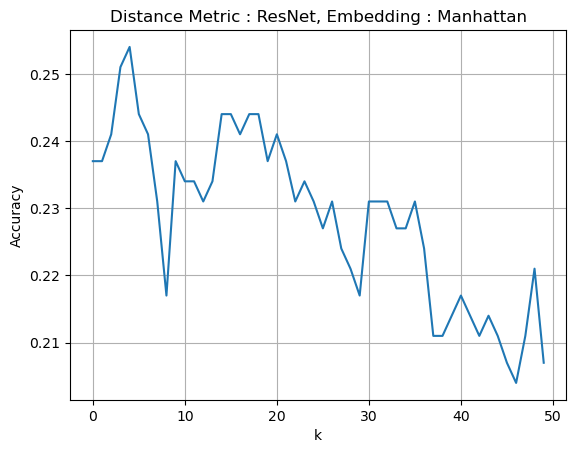

In [282]:
knn = KNN(1,'ResNet','Manhattan')
knn.loadDataset('./../../data/data.npy')
knn.splitDataset(0.8)

# takes about 1m 45s 
accuracy_plot(knn,'ResNet','Manhattan')

In [283]:
# --------------VECTORIZED KNN--------------------------
# creating a KNN object and loading,splitting dataset   
knn2 = KNN(1,'VIT','Euclidean')
knn2.printParmeters()
knn2.loadDataset('./../../data/data.npy')
knn2.splitDataset(0.75)


-------------------------------------
       Parameters of the KNN         
> k = 1
> encoder = VIT
> distance metric = Euclidean
-------------------------------------


In [284]:
# now predicting TestX and calculating performance
knn2.k = 6
knn2.dist_metric = 'Euclidean'
knn2.emb = 0

start_time = time.time()
knn2.predict_vectorized()
end_time = time.time()


knn2.calc_performance()
print('Vectorized KNN results : ')
knn2.printPerformance()

# saving observations in results alongwith run_time
save_observations(knn2,end_time-start_time)


Vectorized KNN results : 
_________________________________________
Accuracy = 0.272
_________________________________________
     		micro	macro	weighted
prec		 0.272 	 0.226 	 0.356
recall		 0.363 	 0.401 	 0.363
f1		 0.311 	 0.212 	 0.326





In [285]:
# Plot inference time for initial KNN model, best KNN model, most optimized KNN model, and the default sklearn KNN model.

# initial model
initial_knn = KNN(5,'ResNet','Euclidean')
initial_knn.loadDataset('./../../data/data.npy')
initial_knn.splitDataset(0.75)
t1 = time.time()
initial_knn.predict()
t2 = time.time()
time1 = t2-t1
initial_knn.calc_performance()
# print('Initial KNN model : ')
# initial_knn.printPerformance()

# best model
best_knn = KNN(14,'ResNet','Manhattan')
best_knn.loadDataset('./../../data/data.npy')
best_knn.splitDataset(0.75)
t1 = time.time()
best_knn.predict()
t2 = time.time()
time2 = t2-t1
best_knn.calc_performance()
# print('Best KNN model : ')
# best_knn.printPerformance()

# most optimized model
most_opt_knn = KNN(1,'VIT','Euclidean')
most_opt_knn.loadDataset('./../../data/data.npy')
most_opt_knn.splitDataset(0.75)
t1 = time.time()
most_opt_knn.predict_vectorized()
t2 = time.time()
time3 = t2-t1
most_opt_knn.calc_performance()
# print('Most Optimized KNN model : ')
# most_opt_knn.printPerformance()

# sklearn inbuilt lib model
data = np.load('./../../data/data.npy',allow_pickle=True)
resnet_flag = True  #True for ResNet, False for VIT
if resnet_flag:
    col_index = 1
else:
    col_index = 2

X = np.array([np.array(embedding).flatten() for embedding in data[:, col_index]])
Y = data[:, 3]
TrainX, TestX, TrainY, TestY = train_test_split(X, Y, test_size=0.25, random_state=np.random.randint(1, 50))
knn = KNeighborsClassifier(5)
knn.fit(TrainX, TrainY)
t1 = time.time()
predictions = knn.predict(TestX)
t2 = time.time()
time4 = t2-t1

acc = round(accuracy_score(TestY, predictions),3)

prec_wt = round(precision_score(TestY, predictions, average='weighted',zero_division=True),3)
recall_wt = round(recall_score(TestY, predictions, average='weighted',zero_division=True),3)
f1_wt = round(f1_score(TestY, predictions, average='weighted',zero_division=True),3)

recall_ma = round(recall_score(TestY, predictions, average='macro',zero_division=True),3)
prec_ma = round(precision_score(TestY, predictions, average='macro',zero_division=True),3)
f1_ma = round(f1_score(TestY, predictions, average='macro',zero_division=True),3)

prec_mi = round(precision_score(TestY, predictions, average='micro',zero_division=True),3)
recall_mi = round(recall_score(TestY, predictions, average='micro',zero_division=True),3)
f1_mi = round(f1_score(TestY, predictions, average='micro',zero_division=True),3)


# Print the evaluation metrics

# print('Default sklearn KNN model : ')
# printTable(acc,prec_mi,prec_ma,prec_wt,recall_mi,recall_ma,recall_wt,f1_mi,f1_ma,f1_wt)

print('--------------------------------------')
print('MODEL\t\t\tInference Time')
print('Initial KNN\t\t',str(round(time1,3)))
print('Best KNN\t\t',str(round(time2,3)))
print('Most Optimized KNN\t',str(round(time3,3)))
print('sklearn KNN\t\t',str(round(time4,3)))



--------------------------------------
MODEL			Inference Time
Initial KNN		 2.644
Best KNN		 2.056
Most Optimized KNN	 0.027
sklearn KNN		 0.023


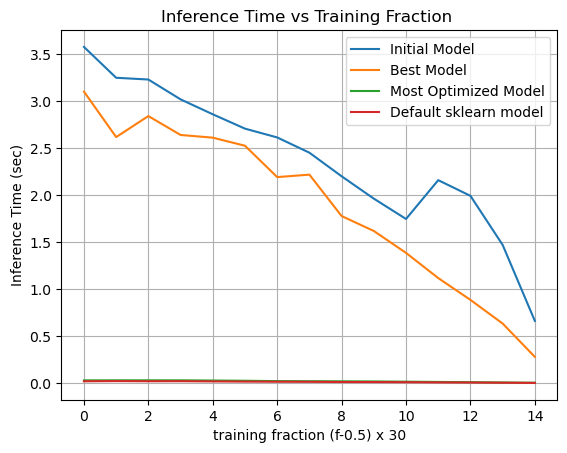

In [286]:
# plot the inference time vs train dataset size for initial KNN model
fractions = np.round((np.arange(15, 30)/30),2)


# initial model
ar = []
for f in fractions:
    initial_knn.splitDataset(f)
    t1 = time.time()
    initial_knn.predict()
    t2 = time.time()
    time1 = t2-t1
    ar.append(time1)
plt.plot(ar,label='Initial Model')
    

# best model
ar = []
for f in fractions:
    best_knn.splitDataset(f)
    t1 = time.time()
    best_knn.predict()
    t2 = time.time()
    time1 = t2-t1
    ar.append(time1)
plt.plot(ar,label='Best Model')
    

# most-optimized model
ar = []
for f in fractions:
    most_opt_knn.splitDataset(f)
    t1 = time.time()
    most_opt_knn.predict_vectorized()
    t2 = time.time()
    time1 = t2-t1
    ar.append(time1)    
plt.plot(ar,label='Most Optimized Model')


# default sklearn model
data = np.load('./../../data/data.npy',allow_pickle=True)
resnet_flag = True  #True for ResNet, False for VIT
if resnet_flag:
    col_index = 1
else:
    col_index = 2
X = np.array([np.array(embedding).flatten() for embedding in data[:, col_index]])
Y = data[:, 3]
    
ar = []
for f in fractions:
    TrainX, TestX, TrainY, TestY = train_test_split(X, Y, test_size=1-f, random_state=np.random.randint(1, 50))
    knn = KNeighborsClassifier(5)
    knn.fit(TrainX, TrainY)
    t1 = time.time()
    predictions = knn.predict(TestX)
    t2 = time.time()
    time1 = t2-t1
    ar.append(time1)

plt.plot(ar,label='Default sklearn model')


plt.xlabel('training fraction (f-0.5) x 30')
plt.ylabel('Inference Time (sec)')
plt.title('Inference Time vs Training Fraction ')
plt.grid()
plt.legend()


plt.show()
